In [1]:
import json
import os

import ffmpegio
import pandas as pd
import plotly.express as px
import torch
from transformers import MobileViTFeatureExtractor, MobileViTForSemanticSegmentation
import gc
from tqdm import tqdm
from sklearn.model_selection import train_test_split


def convert_number(num: str) -> int:
    """
    Убирает суффиксы К и М из чисел

    :param num: число, которое нужно преобразовать;
    :return: преобразованное число
    """
    if 'K' in num:
        return int(float(num[:-1]) * 1_000)
    elif 'M' in num:
        return int(float(num[:-1]) * 1_000_000)
    else:
        return int(num)


renderer = 'svg'  # Как будет сохраняться график в ноутбуке
ffmpegio.set_path(r"..\..\ffmpeg-master-latest-win64-gpl\bin")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# EDA


## Распределение отношения лайков к просмотрам

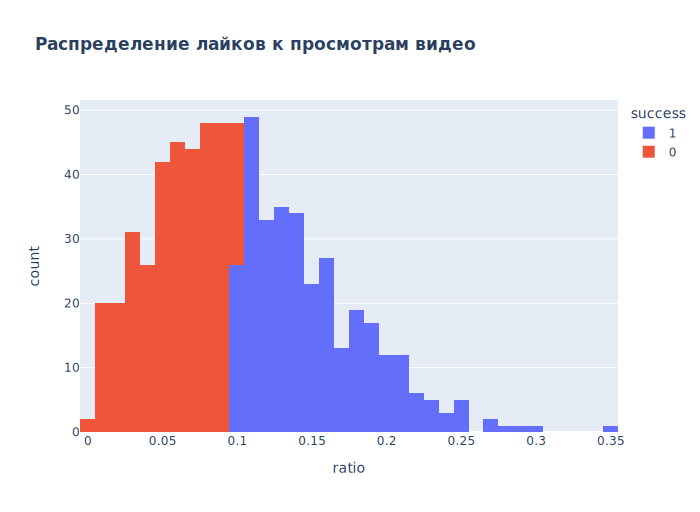

In [2]:
data = pd.DataFrame(
    columns=['theme', 'likes', 'views', 'ratio', 'post_link', 'description', 'preview_path', 'video_path']
)

for json_file in os.listdir('../../data/jsons'):

    if json_file.endswith('.json'):
        posts_data = json.load(open(f"{'../../data/jsons'}/{json_file}", 'r'))
        for post in posts_data:
            if 'likes' in post and 'views' in post:
                likes = convert_number(post['likes'])
                views = convert_number(post['views'])
                data.loc[data.shape[0] + 1] = [
                    json_file.split('-')[1].split('.')[0],
                    likes,
                    views,
                    likes / views,
                    post['post_link'],
                    post['description'],
                    post['preview_path'],
                    post['video_path'],
                ]

data = data[data.post_link.duplicated() == False].reset_index(drop=True)
data['success'] = (data.ratio > 0.1) * 1
fig_distr_lv = px.histogram(data, x='ratio', title='<b>Распределение лайков к просмотрам видео</b>', color='success')
fig_distr_lv.show(renderer=renderer, height=512, widht=1024, autosize=False)

In [3]:
data.sample(5, random_state=21)

,theme,likes,views,ratio,post_link,description,preview_path,video_path,success
496,memes,4099999,28900000,0.141868,https://www.tiktok.com/@felix_8099/video/70839...,#meme #memes #lore #african #africanlore ...,../../data/previews/7083924753177677062.jpg,../../data/videos/video-7083924753177677062.mp4,1
506,memes,1400000,15500000,0.090323,https://www.tiktok.com/@area_of_meme/video/711...,TRY NOT TO LAUGH #funny #funnyvideos #fyp #...,../../data/previews/7112823560283983110.jpg,../../data/videos/video-7112823560283983110.mp4,0
65,artificialintelligence,108500,1500000,0.072333,https://www.tiktok.com/@funx.arts/video/715256...,I couldn't believe what happened in the end! C...,../../data/previews/7152566906505989382.jpg,../../data/videos/video-7152566906505989382.mp4,0
500,memes,5500000,40400000,0.136139,https://www.tiktok.com/@dsl1983/video/70889567...,#CapCut #dsl1983 #lowquality #lowqualitymem...,../../data/previews/7088956736110955782.jpg,../../data/videos/video-7088956736110955782.mp4,1
312,learning,2200000,12200000,0.180328,https://www.tiktok.com/@billyvsco/video/706618...,Always a level of respect and privacy around h...,../../data/previews/7066182198269037870.jpg,../../data/videos/video-7066182198269037870.mp4,1


# Создание модели для выделения смыслов из кадров видео и превью

## Модель MobileViT

In [4]:
feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/deeplabv3-mobilevit-small")
mobile_vit = MobileViTForSemanticSegmentation.from_pretrained("apple/deeplabv3-mobilevit-small")

## Дополнительные слои пулингов

In [5]:
class VBarModel(torch.nn.Module):

    def __init__(self, _model: MobileViTForSemanticSegmentation):
        super().__init__()
        self.mobile_vit = _model
        self.convs = torch.nn.Sequential(
            torch.nn.MaxPool2d(2, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.mobile_vit(x).logits
        x = self.convs(x)
        return x


torch.cuda.empty_cache()

In [6]:
vktrbr_model = VBarModel(mobile_vit).to(device)

pic = ffmpegio.image.read(data.preview_path.iloc[0])
pic = feature_extractor(images=pic, return_tensors='pt')['pixel_values']
pic = pic.to(device)

out_pic = vktrbr_model(pic).detach().to('cpu')
out_pic_dim = out_pic.shape[1]
out_pic.shape

torch.Size([1, 21, 16, 16])

# Применение модели к каждому кадру модели

## Тест на одном видео

In [7]:
FPS_DIV = 3  # Во сколько раз уменьшаем fps. Все видео в тиктоке 30 fps. По сути анализируем с fps = 10
MAX_LENGTH = 90  # Фиксированное количество кадров. То есть обрезаем каждое видео до max_length / 30 * fps_mult секунд

BATCH_SIZE = 4  # Количество кадров для обработки батчем

In [8]:
def read_video(path: str) -> torch.Tensor:
    """
    Читает видео и возвращает тензор с фичами
    """

    _, video = ffmpegio.video.read(path, t=10.0)
    video = video[::FPS_DIV][:MAX_LENGTH]

    out_seg_video = []

    for i in range(0, video.shape[0], BATCH_SIZE):
        frames = [video[j] for j in range(i, min(i + BATCH_SIZE, video.shape[0]))]
        frames = feature_extractor(images=frames, return_tensors='pt')['pixel_values']

        out = vktrbr_model(frames.to(device)).detach().to('cpu')
        out_seg_video.append(out)

        del frames, out
        gc.collect()
        torch.cuda.empty_cache()

    return torch.cat(out_seg_video)

In [9]:
vid = read_video(data.video_path.sample(1, random_state=21).values[0])
vid.shape

torch.Size([90, 21, 16, 16])

## Применяем ко всем видео

In [10]:
vid_torch_paths = []

for idx, post in tqdm(data.iterrows()):
    break
    if os.path.exists(post.video_path.replace('mp4', 'th').replace('videos', 'videos-torch')):
        continue

    if os.path.exists(post.preview_path):
        tensor_path = post.video_path.replace('mp4', 'th').replace('videos', 'videos-torch')

        vid = read_video(post.video_path)
        torch.save(vid, tensor_path)

        del tensor_path
        del vid

        gc.collect()


0it [00:00, ?it/s]


# Обработаем превью

In [11]:
vid_torch_paths = []

for idx, post in tqdm(data.iterrows()):
    break
    if os.path.exists(post.preview_path.replace('jpg', 'th').replace('previews', 'previews-torch')):
        continue

    if os.path.exists(post.preview_path):
        tensor_path = post.preview_path.replace('jpg', 'th').replace('previews', 'previews-torch')

        preview = read_video(post.preview_path)
        torch.save(preview, tensor_path)

        del tensor_path
        del preview

        gc.collect()



0it [00:00, ?it/s]


In [12]:
data['torch_video_path'] = data.video_path.str.replace('mp4', 'th').str.replace('videos', 'videos-torch')
data['torch_preview_path'] = data.preview_path.str.replace('jpg', 'th').str.replace('previews', 'previews-torch')

# Посты, обработанные успешно

In [13]:
data = data[
    data.apply(lambda x: os.path.exists(x.torch_video_path) and os.path.exists(x.torch_preview_path), axis='columns')]

In [14]:
data.shape

(653, 11)

# Модель для понимания видео после обработки кадров

In [60]:
from torch.utils.data import Dataset, DataLoader


class VideoModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        p = 0.5
        self.pic_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(21, 128, (2, 2), stride=2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, (2, 2), stride=2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout2d(p),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256, 256, (4, 4), stride=2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout2d(p),
            torch.nn.Flatten()
        )

        self.vid_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(21, 128, (2, 2), stride=2),
            torch.nn.BatchNorm2d(128),
            torch.nn.Tanh(),
            torch.nn.Conv2d(128, 256, (2, 2), stride=2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout2d(p),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(256, 512, (2, 2), stride=2),
            torch.nn.BatchNorm2d(512),
            torch.nn.Dropout2d(p),
            torch.nn.Flatten()
        )

        self.lstm = torch.nn.LSTM(2048, 256, 1, batch_first=True, bidirectional=True)
        self.fc1 = torch.nn.Linear(256 * 2, 1024)
        self.fc_norm = torch.nn.BatchNorm1d(256 * 2)
        self.tanh = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(1024, 2)
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(p)

        # xaiver init
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Conv3d):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        """
        Использует превью как начальное скрытое состояние, а кадры видео как последовательность.
        video[0] - превью, video[1] - видео

        :param video: torch.Tensor, shape = (batch_size, frames + 1, 1344)
        """
        _batch_size = video.shape[0]

        _preview = video[:, 0, :, :]
        _video = video[:, 1:, :, :]

        h0 = self.pic_cnn(_preview).unsqueeze(0)
        h0 = torch.nn.functional.pad(h0, (0, 0, 0, 0, 0, 1))
        c0 = torch.zeros_like(h0)

        _video = self.vid_cnn(_video.reshape(-1, 21, 16, 16))
        _video = _video.reshape(_batch_size, 90, -1)

        context, _ = self.lstm(_video, (h0, c0))
        out = self.fc_norm(context[:, -1])
        out = self.tanh(self.fc1(out))
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out


class VideoPreprocessedDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.videos = [torch.load(data.torch_video_path.iloc[i]) for i in range(len(data))]
        self.previews = [torch.load(data.torch_preview_path.iloc[i]) for i in range(len(data))]
        self.target = data.success.values

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        out_video = self.videos[idx]
        frames = out_video.shape[0]

        # padding
        out_video = torch.nn.functional.pad(out_video, (0, 0, 0, 0, 0, 0, MAX_LENGTH + 1 - frames, 0))

        return out_video, torch.tensor(self.target[idx]).long()

In [61]:
train_dataset, valid_dataset = train_test_split(data, test_size=0.5, random_state=21)
train_dataset = VideoPreprocessedDataset(train_dataset)
valid_dataset = VideoPreprocessedDataset(valid_dataset)

In [62]:
def train(model, train_loader, optimizer, criterion, _device):
    model.train()
    train_loss = 0

    for batch_idx, (_data, target) in enumerate(train_loader):
        _data, target = _data.to(device), target.to(_device)
        optimizer.zero_grad()
        output = model(_data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

    train_loss /= len(train_loader)
    return train_loss


def test(model, test_loader, _device):
    # Accuracy
    model.eval()
    cnt = 0
    with torch.no_grad():
        for batch_idx, (_data, target) in enumerate(test_loader):
            _data, target = _data.to(device), target.to(_device)
            output = model(_data)
            cnt += torch.sum(output.argmax(dim=1) == target).item()

    return cnt / len(test_loader.dataset)


def train_model(_train_dataset, _valid_dataset, model, batch_size=32, epochs=10):
    max_acc = 0
    _device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(_device)
    optimizer = torch.optim.RAdam(model.parameters(), weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(_valid_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion, _device)

        train_metric = test(model, train_loader, _device)
        test_metric = test(model, test_loader, _device)

        print(f"Epoch: {epoch + 1:3d} \t train loss: {train_loss:.4f} "
              f"\t train acc: {train_metric:.4f} \t test acc: {test_metric:.4f}")

        torch.cuda.empty_cache()
        gc.collect()

        if test_metric > max_acc:
            max_acc = test_metric
            torch.save(model, './best-model.th')

    model = torch.load('./best-model.th')
    return model

In [63]:
video_model = VideoModel()
vm = train_model(train_dataset, valid_dataset, video_model, epochs=10, batch_size=32)

Epoch:   1 	 train loss: 0.6803 	 train acc: 0.5552 	 test acc: 0.5076
Epoch:   2 	 train loss: 0.7077 	 train acc: 0.6288 	 test acc: 0.5138
Epoch:   3 	 train loss: 0.6815 	 train acc: 0.6871 	 test acc: 0.5810
Epoch:   4 	 train loss: 0.6763 	 train acc: 0.7025 	 test acc: 0.5872
Epoch:   5 	 train loss: 0.6653 	 train acc: 0.7270 	 test acc: 0.5902
Epoch:   6 	 train loss: 0.6489 	 train acc: 0.7362 	 test acc: 0.5749
Epoch:   7 	 train loss: 0.6279 	 train acc: 0.7546 	 test acc: 0.5749
Epoch:   8 	 train loss: 0.6186 	 train acc: 0.7761 	 test acc: 0.5933
Epoch:   9 	 train loss: 0.6015 	 train acc: 0.8037 	 test acc: 0.5841
Epoch:  10 	 train loss: 0.6077 	 train acc: 0.8344 	 test acc: 0.5657


In [64]:
video_model = video_model.eval()

In [71]:
probs = torch.zeros(len(valid_dataset), requires_grad=False)

for i, (vid, target) in enumerate(DataLoader(valid_dataset, batch_size=1, shuffle=False)):
    probs[i] = video_model(vid.to(device))[:, 1].detach().to('cpu')
    vid.detach()

In [72]:
from nueramic_mathml.ml.metrics import auc_roc, accuracy

In [77]:
auc_roc(
    torch.tensor(valid_dataset.target),
    probs
)

0.5999775068487544

In [73]:
2 * auc_roc(
    torch.tensor(valid_dataset.target),
    probs
) - 1

0.1999550136975088

In [74]:
accuracy(
    torch.tensor(valid_dataset.target),
    torch.ones_like(torch.tensor(valid_dataset.target)) * 0
)

0.5229358077049255

In [75]:
accuracy(
    torch.tensor(valid_dataset.target),
    (probs > 0.5) * 1
)

0.5932721495628357